### exp: eqtl prediction, sign prediction, dnabert2 for machine learning

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score,recall_score, f1_score,roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
model_size = ['small','middle','large']
model_list = ['xgboost','lightgbm','random forest','knn','svm']
tissue = 'Esophagus_Mucosa'
data_path = '../../../../../datasets_embedding/dnabert2/eqtl_datasets/sign_prediction/' + tissue + '/'

#### small model

In [3]:
model = model_size[0]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

merged_data = pd.concat([train_data, valid_data, test_data]).reset_index(drop=True) # for machine learning, grid search
# new split
train_data = merged_data[0:int(0.9*len(merged_data))].reset_index(drop=True)
test_data = merged_data[int(0.9*len(merged_data)):].reset_index(drop=True)

sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['dnabert_before'][i].flatten().tolist()
    feature_list += train_data['dnabert_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['label'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['dnabert_before'][i].flatten().tolist()
    feature_list += test_data['dnabert_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['label'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

        phenotype_id             variant_id  tss_distance       maf  \
0  ENSG00000242485.5   chr1_1407232_G_C_b38           -81  0.160584   
1  ENSG00000224387.1   chr1_2493455_T_C_b38           197  0.270073   
2  ENSG00000235241.1  chr1_16889585_T_C_b38           490  0.244526   
3  ENSG00000090432.6  chr1_20508117_C_A_b38           -44  0.106880   
4  ENSG00000218510.6  chr1_22025454_G_T_b38           923  0.207521   

  ma_samples ma_count  pval_nominal     slope  slope_se  label  \
0        123      132  9.459473e-20  0.291594  0.030113      1   
1        192      222  4.712999e-24  0.487753  0.044613      1   
2        190      201  1.591893e-31  0.884643  0.068237      1   
3         82       87  8.911781e-33  0.500833  0.037676      1   
4        127      149  5.254031e-30  0.611722  0.048697      1   

                                          seq_before  \
0  gcactccagcctgggtgacagcgcgagactccgtctcggggtaaga...   
1  GGCACAGCTGACACCGCAGGAGAGCTCGAGGAACATGCCCTGTGCA...   
2  ggcct

In [4]:
print(train_data['label'].unique())

[1 0]


##### model 1: xgboost

In [5]:
# model 1: xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# 1:search 'n_estimators'
cv_params = {'n_estimators': np.linspace(100, 1000, 10, dtype=int)} # 1000
cv_params = {'n_estimators': np.linspace(1000, 3000, 10, dtype=int)} # 1444
cv_params = {'n_estimators': np.linspace(100, 200, 20, dtype=int)} # 121
#cv_params = {'n_estimators': np.linspace(111, 131, 20, dtype=int)} # 117

# 2:search 'max_depth'
#cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 2

xgb_model = xgb.XGBClassifier(n_estimators=117)
gs = GridSearchCV(xgb_model, cv_params, verbose=2, refit=True, cv=5, n_jobs=-1)
gs.fit(X_train,Y_train)
gs.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 1444}

accuracy:0.5531914893617021
precision:0.4782608695652174
recall:0.55
f1-score:0.5116279069767442


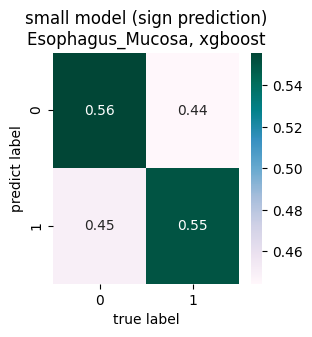

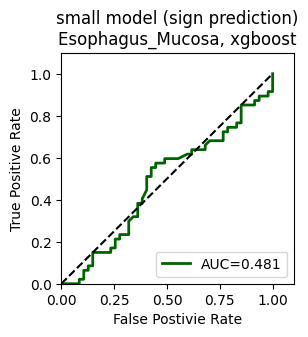

In [14]:
ml_model = model_list[0]
clf_xgb = xgb.XGBClassifier(n_estimators=117, max_depth=2) # from grid search
clf_xgb.fit(X_train,Y_train)

y_score = clf_xgb.predict(X_test)                                   
y_score_pro = clf_xgb.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig('images_shuffled/cm-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr_xgb, tpr_xgb, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_xgb = auc(fpr_xgb, tpr_xgb)
#print("AUC : ", auc_xgb)
ax = plt.subplots(figsize=(3,3))
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr_xgb, tpr_xgb, linewidth = 2,label='AUC=%.3f' % auc_xgb,color='#006400')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('images_shuffled/auc-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:lightgbm

In [17]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

# 1:search 'max_depth'
cv_params = {'max_depth': np.linspace(1, 100, 11, dtype=int)} # 1

# 2:search 'num_leaves'
cv_params = {'num_leaves': np.linspace(3, 100, 11, dtype=int)} # 3

gbm = lgb.LGBMClassifier(max_depth=1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, n_jobs=-1)
gsearch.fit(X_train, Y_train)
gsearch.best_params_

{'num_leaves': 3}

accuracy:0.5531914893617021
precision:0.4782608695652174
recall:0.55
f1-score:0.5116279069767442


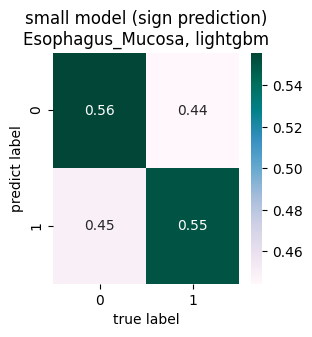

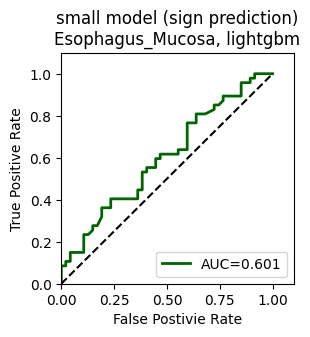

In [18]:
ml_model = model_list[1]
clf_lgb = lgb.LGBMClassifier(max_depth=1, num_leaves=3)
clf_lgb.fit(X_train,Y_train)

y_score = clf_lgb.predict(X_test)                                   
y_score_pro = clf_lgb.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig('images_shuffled/cm-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr_xgb, tpr_xgb, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_xgb = auc(fpr_xgb, tpr_xgb)
#print("AUC : ", auc_xgb)
ax = plt.subplots(figsize=(3,3))
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr_xgb, tpr_xgb, linewidth = 2,label='AUC=%.3f' % auc_xgb,color='#006400')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('images_shuffled/auc-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: random forest

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 1:search 'n_estimators'
cv_params = {'n_estimators': np.linspace(100, 1000, 10, dtype=int)} # 200
cv_params = {'n_estimators': np.linspace(100, 300, 10, dtype=int)} # 188
cv_params = {'n_estimators': np.linspace(160, 200, 40, dtype=int)} # 162

# 2:search 'max_depth'
cv_params = {'max_depth': np.linspace(1, 100, 10, dtype=int)} # 89

rfModel = RandomForestClassifier(n_estimators=162)
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True)
grid.fit(X_train, Y_train)
grid.best_params_

{'max_depth': 89}

accuracy:0.48936170212765956
precision:0.375
recall:0.3
f1-score:0.33333333333333326


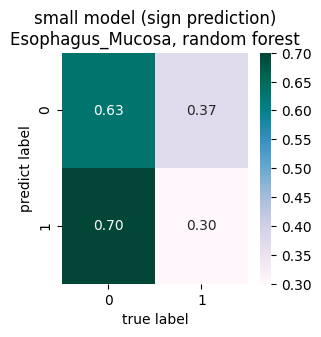

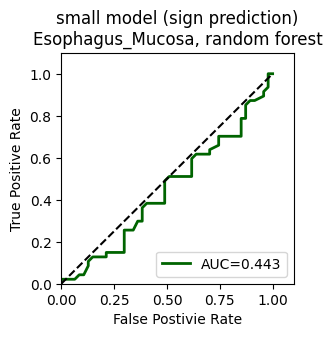

In [24]:
ml_model = model_list[2]
clf_rf = RandomForestClassifier(n_estimators=162, max_depth=89)
clf_rf.fit(X_train,Y_train)

y_score = clf_rf.predict(X_test)                                   
y_score_pro = clf_rf.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig('images_shuffled/cm-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr_xgb, tpr_xgb, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_xgb = auc(fpr_xgb, tpr_xgb)
#print("AUC : ", auc_xgb)
ax = plt.subplots(figsize=(3,3))
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr_xgb, tpr_xgb, linewidth = 2,label='AUC=%.3f' % auc_xgb,color='#006400')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('images_shuffled/auc-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 4: knn

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# 1:search 'n_estimators'
paramGride = {'n_neighbors': np.linspace(100, 1000, 10, dtype=int)} # 300
paramGride = {'n_neighbors': np.linspace(200, 400, 10, dtype=int)} # 222

knnModel = KNeighborsClassifier()
grid = GridSearchCV(
    knnModel,paramGride,cv = 5,return_train_score = True)
grid = grid.fit(X_train,Y_train)
grid.best_params_

c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py", line 666, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py", line 

{'n_neighbors': 222}

accuracy:0.425531914893617
precision:0.3793103448275862
recall:0.55
f1-score:0.4489795918367347


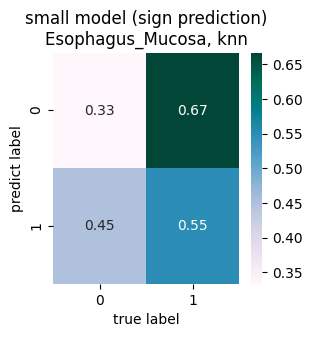

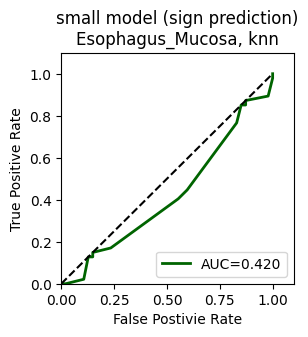

In [27]:
ml_model = model_list[3]
clf_knn = KNeighborsClassifier(n_neighbors = 222)
clf_knn.fit(X_train,Y_train)

y_score = clf_knn.predict(X_test)                                   
y_score_pro = clf_knn.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig('images_shuffled/cm-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr_xgb, tpr_xgb, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_xgb = auc(fpr_xgb, tpr_xgb)
#print("AUC : ", auc_xgb)
ax = plt.subplots(figsize=(3,3))
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr_xgb, tpr_xgb, linewidth = 2,label='AUC=%.3f' % auc_xgb,color='#006400')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('images_shuffleds/auc-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 5: svm

In [30]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# 1:search 'gamma'
cv_params = {'gamma': np.linspace(1e-4, 100, 10, dtype=int)} # 33
cv_params = {'gamma': np.linspace(1e-2, 80, 10, dtype=int)} # 8

# 2:search 'C'
cv_params = {'C': np.linspace(1e-4, 100, 10, dtype=int)} # 11

svmModel = SVC(gamma=8)
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True)
grid = grid.fit(X_train,Y_train)
grid.best_params_

c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py", line 251, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "c:\Users\Administrator\AppData\Loc

{'C': 11}

accuracy:0.574468085106383
precision:0.0
recall:0.0
f1-score:0.0


c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


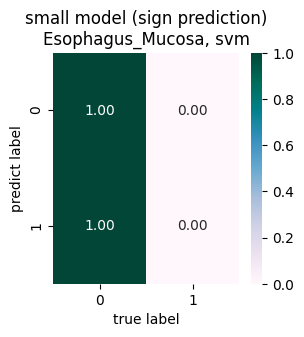

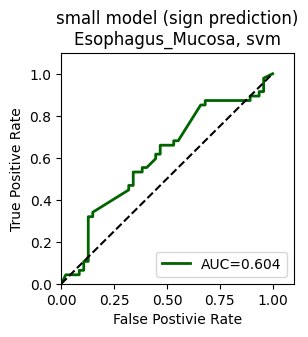

In [31]:
ml_model = model_list[4]
clf_svm = SVC(probability = True, gamma = 8, C = 11)
clf_svm.fit(X_train,Y_train)

y_score = clf_svm.predict(X_test)                                   
y_score_pro = clf_svm.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig('images_shuffled/cm-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr_xgb, tpr_xgb, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_xgb = auc(fpr_xgb, tpr_xgb)
#print("AUC : ", auc_xgb)
ax = plt.subplots(figsize=(3,3))
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr_xgb, tpr_xgb, linewidth = 2,label='AUC=%.3f' % auc_xgb,color='#006400')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('images_shuffled/auc-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

#### middle model

In [3]:
model = model_size[1]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

merged_data = pd.concat([train_data, valid_data, test_data]).reset_index(drop=True) # for machine learning, grid search
# new split
train_data = merged_data[0:int(0.9*len(merged_data))].reset_index(drop=True)
test_data = merged_data[int(0.9*len(merged_data)):].reset_index(drop=True)

sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['dnabert_before'][i].flatten().tolist()
    feature_list += train_data['dnabert_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['label'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['dnabert_before'][i].flatten().tolist()
    feature_list += test_data['dnabert_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['label'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

         phenotype_id            variant_id  tss_distance       maf  \
0  ENSG00000187961.13   chr1_959193_G_A_b38         -1394  0.087591   
1   ENSG00000272512.1   chr1_989148_C_A_b38         -8903  0.452926   
2  ENSG00000178821.12  chr1_1925307_C_A_b38          6034  0.496231   
3   ENSG00000229393.1  chr1_2493455_T_C_b38         -1024  0.270073   
4  ENSG00000116213.15  chr1_3654319_C_T_b38          1558  0.492701   

  ma_samples ma_count  pval_nominal     slope  slope_se  label  \
0         69       72  1.511788e-20  0.456110  0.045976      1   
1        296      373  7.933526e-38  0.651714  0.044649      1   
2        319      408  1.560427e-29  0.608696  0.048948      1   
3        192      222  3.880312e-28  0.540057  0.044780      1   
4        307      405  8.474306e-53  0.511822  0.027893      1   

                                          seq_before  \
0  ACACCTGCAGGCACACAGGCATTCATGGATACACGTGCATACACAC...   
1  cttccttttaatgaagtctaatttgcccatttttcttgatgtatta...   
2  cgtgg

##### model 1: xgboost

In [4]:
# model 1: xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# 1:search 'n_estimators'
cv_params = {'n_estimators': np.linspace(100, 1000, 10, dtype=int)} # 200
cv_params = {'n_estimators': np.linspace(100, 300, 10, dtype=int)} # 188
cv_params = {'n_estimators': np.linspace(150, 250, 10, dtype=int)} # 197
cv_params = {'n_estimators': np.linspace(184, 204, 20, dtype=int)} # 198

# 2:search 'max_depth'
cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 4

xgb_model = xgb.XGBClassifier(n_estimators=198)
gs = GridSearchCV(xgb_model, cv_params, verbose=2, refit=True, cv=5, n_jobs=-1)
gs.fit(X_train,Y_train)
gs.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'max_depth': 4}

accuracy:0.5689655172413793
precision:0.7058823529411765
recall:0.6153846153846154
f1-score:0.6575342465753424


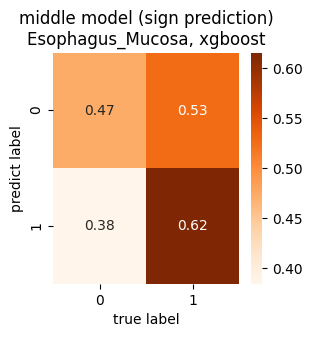

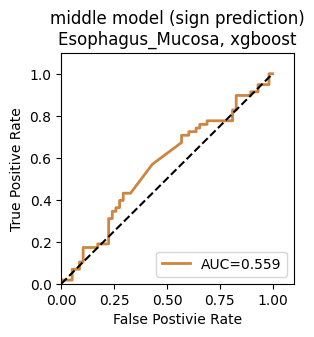

In [5]:
ml_model = model_list[0]
clf_xgb = xgb.XGBClassifier(n_estimators=198, max_depth=4) # from grid search
clf_xgb.fit(X_train,Y_train)

y_score = clf_xgb.predict(X_test)                                   
y_score_pro = clf_xgb.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='Oranges', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig('images_shuffled/cm-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr_xgb, tpr_xgb, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_xgb = auc(fpr_xgb, tpr_xgb)
#print("AUC : ", auc_xgb)
ax = plt.subplots(figsize=(3,3))
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr_xgb, tpr_xgb, linewidth = 2,label='AUC=%.3f' % auc_xgb,color='#CD853F')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('images_shuffled/auc-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:lightgbm

In [6]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

# 1:search 'max_depth'
cv_params = {'max_depth': np.linspace(1, 100, 11, dtype=int)} # 10
cv_params = {'max_depth': np.linspace(5, 15, 10, dtype=int)} # 8

# 2:search 'num_leaves'
cv_params = {'num_leaves': np.linspace(3, 100, 10, dtype=int)} # 13

gbm = lgb.LGBMClassifier(max_depth=8)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, n_jobs=-1)
gsearch.fit(X_train, Y_train)
gsearch.best_params_

{'num_leaves': 13}

accuracy:0.603448275862069
precision:0.7666666666666667
recall:0.5897435897435898
f1-score:0.6666666666666667


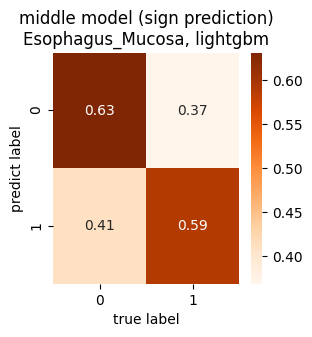

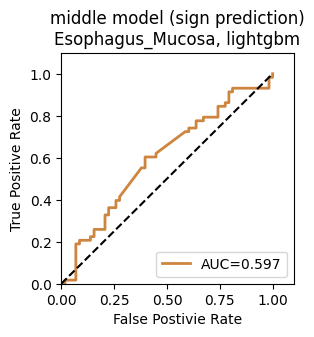

In [7]:
ml_model = model_list[1]
clf_lgb = lgb.LGBMClassifier(max_depth=8, num_leaves=13)
clf_lgb.fit(X_train,Y_train)

y_score = clf_lgb.predict(X_test)                                   
y_score_pro = clf_lgb.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='Oranges', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig('images_shuffled/cm-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr_xgb, tpr_xgb, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_xgb = auc(fpr_xgb, tpr_xgb)
#print("AUC : ", auc_xgb)
ax = plt.subplots(figsize=(3,3))
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr_xgb, tpr_xgb, linewidth = 2,label='AUC=%.3f' % auc_xgb,color='#CD853F')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('images_shuffled/auc-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: random forest

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 1:search 'n_estimators'
cv_params = {'n_estimators': np.linspace(100, 1000, 10, dtype=int)} # 1000
cv_params = {'n_estimators': np.linspace(1000, 3000, 10, dtype=int)} # 1000
cv_params = {'n_estimators': np.linspace(500, 1500, 10, dtype=int)} # 944
cv_params = {'n_estimators': np.linspace(800, 1200, 40, dtype=int)} # 1097

# 2:search 'max_depth'
cv_params = {'max_depth': np.linspace(1, 100, 10, dtype=int)} # 78

rfModel = RandomForestClassifier(n_estimators=1097)
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True)
grid.fit(X_train, Y_train)
grid.best_params_

{'max_depth': 78}

accuracy:0.5517241379310345
precision:0.7096774193548387
recall:0.5641025641025641
f1-score:0.6285714285714286


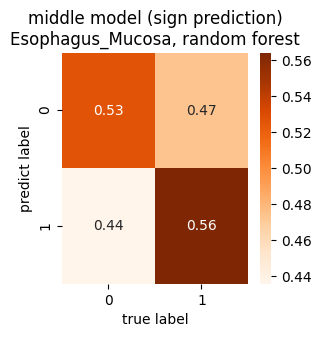

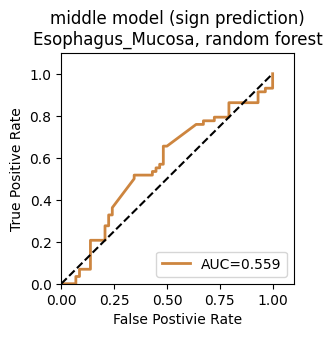

In [9]:
ml_model = model_list[2]
clf_rf = RandomForestClassifier(n_estimators=1097, max_depth=78)
clf_rf.fit(X_train,Y_train)

y_score = clf_rf.predict(X_test)                                   
y_score_pro = clf_rf.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='Oranges', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig('images_shuffled/cm-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr_xgb, tpr_xgb, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_xgb = auc(fpr_xgb, tpr_xgb)
#print("AUC : ", auc_xgb)
ax = plt.subplots(figsize=(3,3))
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr_xgb, tpr_xgb, linewidth = 2,label='AUC=%.3f' % auc_xgb,color='#CD853F')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('images_shuffled/auc-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 4: knn

In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# 1:search 'n_estimators'
paramGride = {'n_neighbors': np.linspace(100, 1000, 10, dtype=int)} # 100
paramGride = {'n_neighbors': np.linspace(20, 100, 10, dtype=int)} # 20
paramGride = {'n_neighbors': np.linspace(5, 20, 5, dtype=int)} # 20

knnModel = KNeighborsClassifier()
grid = GridSearchCV(
    knnModel,paramGride,cv = 5,return_train_score = True)
grid = grid.fit(X_train,Y_train)
grid.best_params_

{'n_neighbors': 20}

accuracy:0.5
precision:0.65625
recall:0.5384615384615384
f1-score:0.5915492957746479


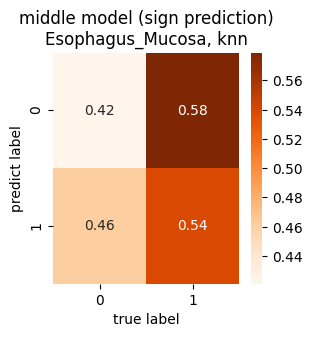

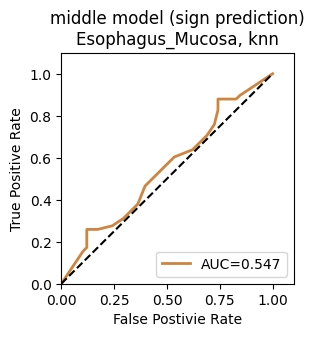

In [53]:
ml_model = model_list[3]
clf_knn = KNeighborsClassifier(n_neighbors = 20)
clf_knn.fit(X_train,Y_train)

y_score = clf_knn.predict(X_test)                                   
y_score_pro = clf_knn.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='Oranges', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig('images_shuffled/cm-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr_xgb, tpr_xgb, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_xgb = auc(fpr_xgb, tpr_xgb)
#print("AUC : ", auc_xgb)
ax = plt.subplots(figsize=(3,3))
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr_xgb, tpr_xgb, linewidth = 2,label='AUC=%.3f' % auc_xgb,color='#CD853F')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('images_shuffled/auc-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 5: svm

In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# 1:search 'gamma'
cv_params = {'gamma': np.linspace(1e-4, 100, 10, dtype=int)} # 44
cv_params = {'gamma': np.linspace(1e-1, 80, 10, dtype=int)} # 44
cv_params = {'gamma': np.linspace(20, 60, 10, dtype=int)} # 42

# 2:search 'C'
cv_params = {'C': np.linspace(1e-4, 100, 10, dtype=int)} # 11

svmModel = SVC(gamma=42)
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True)
grid = grid.fit(X_train,Y_train)
grid.best_params_

c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py", line 251, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "c:\Users\Administrator\AppData\Loc

{'C': 11}

accuracy:0.39655172413793105
precision:0.625
recall:0.2564102564102564
f1-score:0.3636363636363636


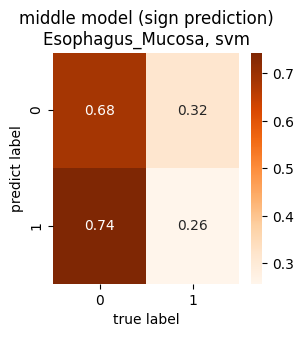

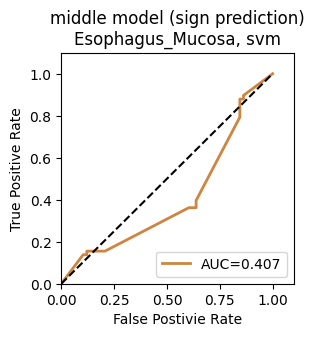

In [11]:
ml_model = model_list[4]
clf_svm = SVC(probability = True, gamma = 42, C = 11)
clf_svm.fit(X_train,Y_train)

y_score = clf_svm.predict(X_test)                                   
y_score_pro = clf_svm.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='Oranges', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig('images_shuffled/cm-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr_xgb, tpr_xgb, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_xgb = auc(fpr_xgb, tpr_xgb)
#print("AUC : ", auc_xgb)
ax = plt.subplots(figsize=(3,3))
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr_xgb, tpr_xgb, linewidth = 2,label='AUC=%.3f' % auc_xgb,color='#CD853F')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('images_shuffled/auc-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

#### large model

In [12]:
model = model_size[2]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

merged_data = pd.concat([train_data, valid_data, test_data]).reset_index(drop=True) # for machine learning, grid search
# new split
train_data = merged_data[0:int(0.9*len(merged_data))].reset_index(drop=True)
test_data = merged_data[int(0.9*len(merged_data)):].reset_index(drop=True)

sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['dnabert_before'][i].flatten().tolist()
    feature_list += train_data['dnabert_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['label'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['dnabert_before'][i].flatten().tolist()
    feature_list += test_data['dnabert_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['label'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

         phenotype_id            variant_id  tss_distance       maf  \
0   ENSG00000228794.8   chr1_841166_A_G_b38         16028  0.255474   
1  ENSG00000131591.17  chr1_1091327_C_A_b38        -25034  0.413625   
2   ENSG00000269737.2  chr1_1655861_G_A_b38        -16129  0.030414   
3   ENSG00000224387.1  chr1_2522989_T_C_b38         29731  0.227901   
4   ENSG00000229393.1  chr1_2522989_T_C_b38         28510  0.227901   

  ma_samples ma_count  pval_nominal     slope  slope_se  label  \
0        184      210  1.305799e-11  0.291182  0.041555      1   
1        274      340  3.169983e-21  0.223220  0.022056      1   
2         25       25  1.190742e-40  1.664350  0.108687      1   
3        148      165  2.671812e-15  0.454298  0.054812      1   
4        148      165  5.657427e-18  0.507771  0.055545      1   

                                          seq_before  \
0  ctgcaacctcttcccgccgggttcacgccattctcctgcctcagcc...   
1  taatttttgtatttttagtagagatggggtttcatcatgttggcca...   
2  tttca

##### model 1: xgboost

In [13]:
# model 1: xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# 1:search 'n_estimators'
cv_params = {'n_estimators': np.linspace(100, 1000, 10, dtype=int)} # 1000
cv_params = {'n_estimators': np.linspace(1000, 3000, 10, dtype=int)} # 2777
cv_params = {'n_estimators': np.linspace(2600, 2800, 20, dtype=int)} # 2610
cv_params = {'n_estimators': np.linspace(2600, 2620, 20, dtype=int)} # 2609

# 2:search 'max_depth'
cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 9

xgb_model = xgb.XGBClassifier(n_estimators=2609)
gs = GridSearchCV(xgb_model, cv_params, verbose=2, refit=True, cv=5, n_jobs=-1)
gs.fit(X_train,Y_train)
gs.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'max_depth': 9}

accuracy:0.5131578947368421
precision:0.48214285714285715
recall:0.7714285714285715
f1-score:0.5934065934065934


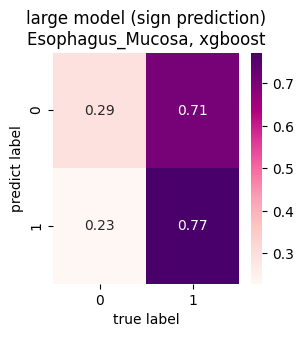

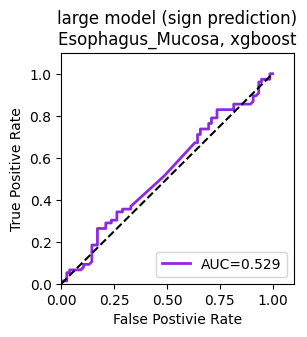

In [14]:
ml_model = model_list[0]
clf_xgb = xgb.XGBClassifier(n_estimators=2609, max_depth=9) # from grid search
clf_xgb.fit(X_train,Y_train)

y_score = clf_xgb.predict(X_test)                                   
y_score_pro = clf_xgb.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='RdPu', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig('images_shuffled/cm-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr_xgb, tpr_xgb, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_xgb = auc(fpr_xgb, tpr_xgb)
#print("AUC : ", auc_xgb)
ax = plt.subplots(figsize=(3,3))
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr_xgb, tpr_xgb, linewidth = 2,label='AUC=%.3f' % auc_xgb,color='#8A2BE2')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('images_shuffled/auc-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:lightgbm

In [18]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

# 1:search 'max_depth'
cv_params = {'max_depth': np.linspace(1, 100, 11, dtype=int)} # 30
cv_params = {'max_depth': np.linspace(20, 40, 20, dtype=int)} # 26

# 2:search 'num_leaves'
cv_params = {'num_leaves': np.linspace(3, 100, 11, dtype=int)} # 12

gbm = lgb.LGBMClassifier(max_depth=26)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, n_jobs=-1)
gsearch.fit(X_train, Y_train)
gsearch.best_params_

{'num_leaves': 12}

accuracy:0.5263157894736842
precision:0.49122807017543857
recall:0.8
f1-score:0.6086956521739131


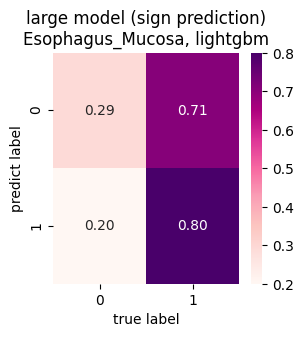

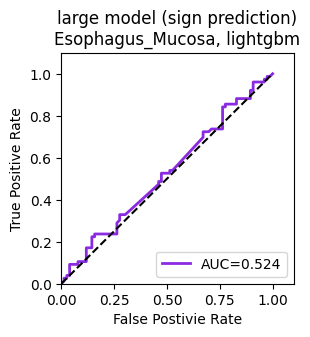

In [19]:
ml_model = model_list[1]
clf_lgb = lgb.LGBMClassifier(max_depth=26, num_leaves=12)
clf_lgb.fit(X_train,Y_train)

y_score = clf_lgb.predict(X_test)                                   
y_score_pro = clf_lgb.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='RdPu', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig('images_shuffled/cm-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr_xgb, tpr_xgb, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_xgb = auc(fpr_xgb, tpr_xgb)
#print("AUC : ", auc_xgb)
ax = plt.subplots(figsize=(3,3))
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr_xgb, tpr_xgb, linewidth = 2,label='AUC=%.3f' % auc_xgb,color='#8A2BE2')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('images_shuffled/auc-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: random forest

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 1:search 'n_estimators'
cv_params = {'n_estimators': np.linspace(100, 1000, 10, dtype=int)} # 800
cv_params = {'n_estimators': np.linspace(700, 900, 10, dtype=int)} # 722
cv_params = {'n_estimators': np.linspace(700, 740, 40, dtype=int)} # 719

# 2:search 'max_depth'
cv_params = {'max_depth': np.linspace(1, 100, 10, dtype=int)} # 1

rfModel = RandomForestClassifier(n_estimators=719)
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True)
grid.fit(X_train, Y_train)
grid.best_params_

{'max_depth': 1}

accuracy:0.4605263157894737
precision:0.4583333333333333
recall:0.9428571428571428
f1-score:0.616822429906542


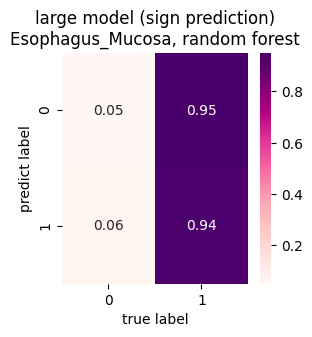

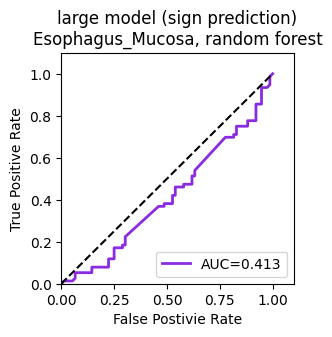

In [25]:
ml_model = model_list[2]
clf_rf = RandomForestClassifier(n_estimators=719, max_depth=1)
clf_rf.fit(X_train,Y_train)

y_score = clf_rf.predict(X_test)                                   
y_score_pro = clf_rf.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='RdPu', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig('images_shuffled/cm-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr_xgb, tpr_xgb, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_xgb = auc(fpr_xgb, tpr_xgb)
#print("AUC : ", auc_xgb)
ax = plt.subplots(figsize=(3,3))
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr_xgb, tpr_xgb, linewidth = 2,label='AUC=%.3f' % auc_xgb,color='#8A2BE2')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('images_shuffled/auc-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 4: knn

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# 1:search 'n_estimators'
paramGride = {'n_neighbors': np.linspace(100, 1000, 10, dtype=int)} # 500
paramGride = {'n_neighbors': np.linspace(400, 600, 10, dtype=int)} # 422
paramGride = {'n_neighbors': np.linspace(400, 500, 10, dtype=int)} # 422
paramGride = {'n_neighbors': np.linspace(410, 430, 20, dtype=int)} # 422

knnModel = KNeighborsClassifier()
grid = GridSearchCV(
    knnModel,paramGride,cv = 5,return_train_score = True)
grid = grid.fit(X_train,Y_train)
grid.best_params_

{'n_neighbors': 422}

accuracy:0.4868421052631579
precision:0.47297297297297297
recall:1.0
f1-score:0.6422018348623852


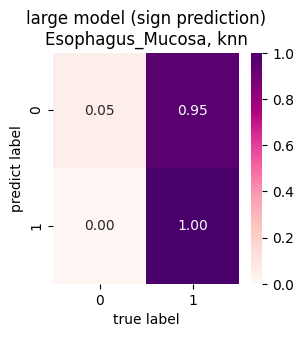

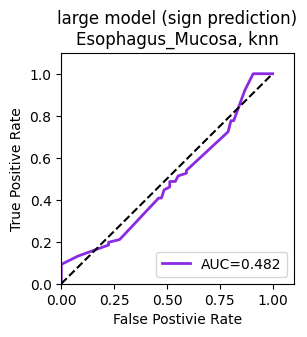

In [30]:
ml_model = model_list[3]
clf_knn = KNeighborsClassifier(n_neighbors = 422)
clf_knn.fit(X_train,Y_train)

y_score = clf_knn.predict(X_test)                                   
y_score_pro = clf_knn.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='RdPu', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig('images_shuffled/cm-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr_xgb, tpr_xgb, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_xgb = auc(fpr_xgb, tpr_xgb)
#print("AUC : ", auc_xgb)
ax = plt.subplots(figsize=(3,3))
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr_xgb, tpr_xgb, linewidth = 2,label='AUC=%.3f' % auc_xgb,color='#8A2BE2')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('images_shuffled/auc-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 5: svm

In [33]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# 1:search 'gamma'
cv_params = {'gamma': np.linspace(1e-4, 100, 10, dtype=int)} # 11
cv_params = {'gamma': np.linspace(1e-2, 20, 10, dtype=int)} # 15

# 2:search 'C'
cv_params = {'C': np.linspace(1e-4, 100, 10, dtype=int)} # 11

svmModel = SVC(gamma=15)
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True)
grid = grid.fit(X_train,Y_train)
grid.best_params_

c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py", line 251, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "c:\Users\Administrator\AppData\Loc

{'C': 11}

accuracy:0.4605263157894737
precision:0.4605263157894737
recall:1.0
f1-score:0.6306306306306306


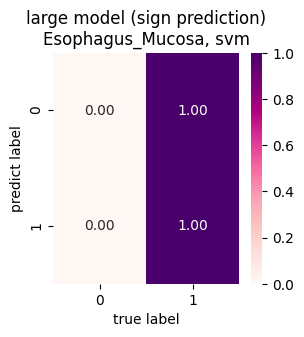

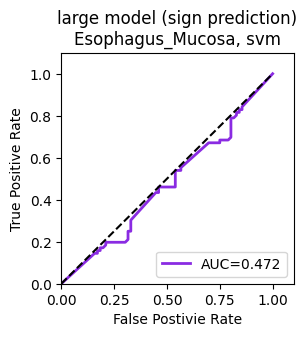

In [34]:
ml_model = model_list[4]
clf_svm = SVC(probability = True, gamma = 15, C = 11)
clf_svm.fit(X_train,Y_train)

y_score = clf_svm.predict(X_test)                                   
y_score_pro = clf_svm.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='RdPu', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig('images_shuffled/cm-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr_xgb, tpr_xgb, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_xgb = auc(fpr_xgb, tpr_xgb)
#print("AUC : ", auc_xgb)
ax = plt.subplots(figsize=(3,3))
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr_xgb, tpr_xgb, linewidth = 2,label='AUC=%.3f' % auc_xgb,color='#8A2BE2')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('images_shuffled/auc-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()